In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import sys
sys.path.append("../../")

In [2]:
# Check Data 
datafile = pd.read_csv("artifacts/DNA-dataset:v0/dataset.csv.gz")
datafile.head()

,Unnamed: 0,chrom,seq,hepg2,k562,sknsh
0,0,chr7,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,0.233601,0.060779,0.047194
1,1,chr1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,0.004565,0.379639,-0.244395
2,2,chr1,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,0.384537,0.036707,-0.004578
3,3,chr15,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...,4.116494,4.508784,3.040183
4,4,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.423444,1.616602,1.335892


In [3]:
# Select data 
small_data = datafile.loc[ (datafile['chrom'] =="chr1") | (datafile['chrom'] =="chr2") |(datafile['chrom'] =="chr3") |(datafile['chrom'] =="chr4")  ]

In [4]:
from src.utils.sequence import seqs_to_one_hot

seq_x = [seqs_to_one_hot(seq)[:, 0, :] for seq in small_data['seq']]
small_data_x = np.array(seq_x)
print(small_data_x.shape) # Data Size 

(203842, 200, 4)


In [5]:
# hepg2_scores = np.array(small_data['hepg2'])

# import matplotlib.pyplot as plt
# plt.hist(hepg2_scores, bins = 'auto')

In [8]:
from grelu.lightning import LightningModel
import grelu.resources
import wandb

DEVICE = "cuda:1"

project_name = 'binary_atac_cell_lines'
artifact = grelu.resources.get_artifact(
    name="model",
    project = project_name,
)

artifact_dir = artifact.download(root='/data/yulai/projects/RLfinetuning_Diffusion_Bioseq/tutorials/Human-enhancer')
artifact_dir

wandb: Downloading large artifact model:latest, 272.79MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


'/data/yulai/projects/RLfinetuning_Diffusion_Bioseq/tutorials/Human-enhancer'

In [10]:
model = LightningModel.load_from_checkpoint("artifacts/model.ckpt")
model.eval()
model.to(DEVICE)


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/grelu/model/models.py:680: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded 

LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [12]:
print(model.data_params['train_seq_len'])
model.data_params['tasks']

200


{'name': ['GM12878', 'HepG2', 'IMR90', 'Jurkat', 'K562', 'SKNSH', 'WTC11']}

In [13]:
import torch

data_loader = torch.utils.data.DataLoader(small_data_x.astype("float32"), batch_size = 128 , num_workers=0)
relabel_y = []

for batch in data_loader:
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    relabel_y.append( model(batch).detach().cpu() ) 

relabel_y = np.concatenate(relabel_y)

In [14]:
relabel_y.shape

(203842, 7, 1)

In [15]:
hepg2_relabel_y = relabel_y[:,1].reshape(-1)
k562_relabel_y = relabel_y[:,4].reshape(-1)

print(hepg2_relabel_y.shape)

(203842,)


(array([3.9148e+04, 1.4758e+04, 9.7630e+03, 7.8660e+03, 6.7270e+03,
        6.2510e+03, 5.5370e+03, 5.0390e+03, 4.6520e+03, 4.3930e+03,
        3.9940e+03, 3.7240e+03, 3.4310e+03, 3.3060e+03, 3.1650e+03,
        2.8490e+03, 2.7140e+03, 2.5080e+03, 2.4490e+03, 2.1800e+03,
        2.1390e+03, 1.9180e+03, 1.8950e+03, 1.8420e+03, 1.7700e+03,
        1.6580e+03, 1.5850e+03, 1.4190e+03, 1.4660e+03, 1.2830e+03,
        1.2010e+03, 1.1660e+03, 1.1130e+03, 1.0450e+03, 1.0530e+03,
        9.7600e+02, 9.8500e+02, 9.7000e+02, 9.0300e+02, 9.0400e+02,
        8.6600e+02, 8.0500e+02, 7.1200e+02, 7.5000e+02, 7.5700e+02,
        7.3400e+02, 6.9900e+02, 6.2900e+02, 6.8700e+02, 6.5000e+02,
        6.3600e+02, 5.6700e+02, 5.9700e+02, 5.6700e+02, 5.8500e+02,
        5.5800e+02, 5.1800e+02, 4.9100e+02, 5.1600e+02, 4.9600e+02,
        4.6700e+02, 4.3500e+02, 4.0600e+02, 4.3700e+02, 4.5300e+02,
        4.2000e+02, 4.0100e+02, 3.8300e+02, 3.8600e+02, 3.7200e+02,
        3.3200e+02, 3.9600e+02, 3.2800e+02, 3.51

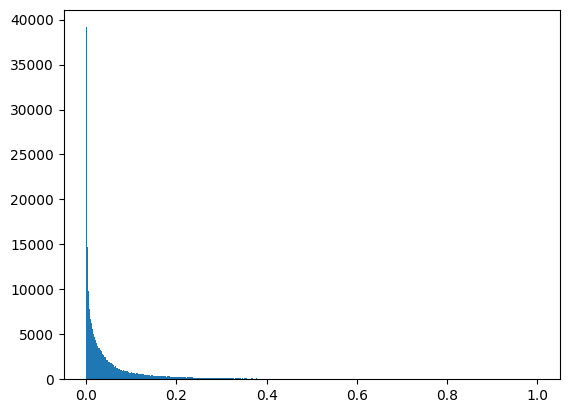

In [17]:
import matplotlib.pyplot as plt
plt.hist(hepg2_relabel_y, bins = 'auto')

0.007818400152027607
0.04571239940822124


(array([67268.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 67268.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0., 69306.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        , 1.06666667, 1.13333333, 1.2       , 1.26666667,
        1.33333333, 1.4       , 1.46666667, 1.53333333, 1.6       ,
        1.66666667, 1.73333333, 1.8       , 1.86666667, 1.93333333,
        2.        ]),
 <BarContainer object of 30 artists>)

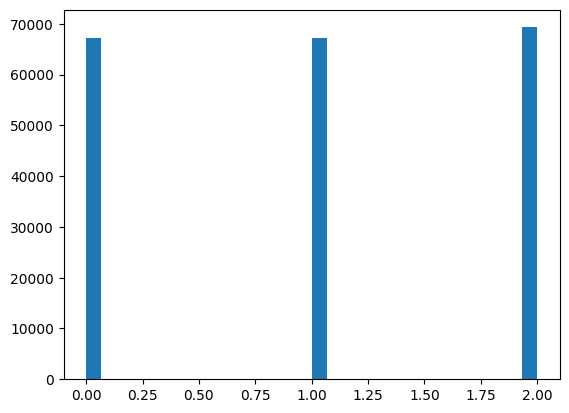

In [29]:
q33 = np.quantile(hepg2_relabel_y, 0.33)
q66 = np.quantile(hepg2_relabel_y, 0.66)

print(q33)
print(q66)

hepg2_relabel_y_list = hepg2_relabel_y.tolist()
discretized_indices = []

for idx,score in enumerate(hepg2_relabel_y_list):
    if score < q33:
        discretized_indices.append(0)
    elif q33 <= score < q66:
        discretized_indices.append(1)
    elif q66 <= score:
        discretized_indices.append(2)

plt.hist(discretized_indices, bins = 'auto')

In [30]:
np.savez_compressed("./artifacts/DNA-dataset:v0/y_HepG2_3class.npz", x = small_data_x, y = np.array(discretized_indices))

: 

(array([3.3863e+04, 1.6179e+04, 1.1247e+04, 8.7710e+03, 7.3620e+03,
        6.2950e+03, 5.5720e+03, 4.9120e+03, 4.5320e+03, 4.1550e+03,
        3.9190e+03, 3.5870e+03, 3.2720e+03, 3.3010e+03, 2.9690e+03,
        2.9740e+03, 2.6740e+03, 2.5790e+03, 2.3540e+03, 2.3180e+03,
        2.1640e+03, 2.0910e+03, 1.9890e+03, 1.9140e+03, 1.8130e+03,
        1.7550e+03, 1.6960e+03, 1.5800e+03, 1.5680e+03, 1.4420e+03,
        1.3770e+03, 1.2750e+03, 1.3240e+03, 1.2420e+03, 1.0980e+03,
        1.0920e+03, 1.1110e+03, 1.0200e+03, 1.0040e+03, 9.3600e+02,
        9.1000e+02, 8.7900e+02, 8.1200e+02, 8.2500e+02, 7.8000e+02,
        7.8100e+02, 7.7600e+02, 6.8600e+02, 7.6500e+02, 6.4900e+02,
        6.8300e+02, 6.1700e+02, 6.1000e+02, 6.1600e+02, 5.6400e+02,
        5.6000e+02, 5.5400e+02, 5.0700e+02, 5.0100e+02, 4.2800e+02,
        4.3700e+02, 4.7600e+02, 4.7000e+02, 4.1600e+02, 4.0800e+02,
        3.7700e+02, 3.9800e+02, 3.7800e+02, 3.6500e+02, 3.6200e+02,
        3.8900e+02, 3.4200e+02, 3.2000e+02, 3.25

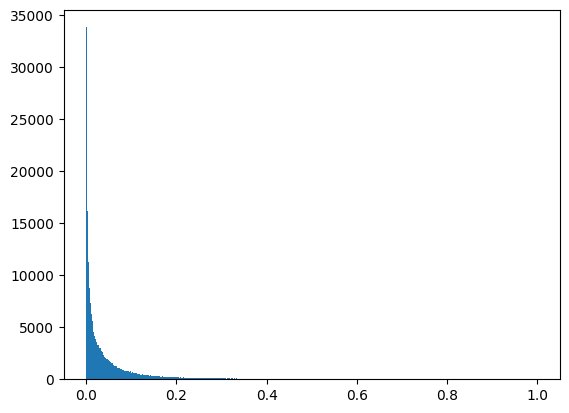

In [18]:
plt.hist(k562_relabel_y, bins = 'auto')

# Save offline data for training

In [20]:
np.savez_compressed("./artifacts/DNA-dataset:v0/y_HepG2_relabel.npz", x = small_data_x, y = hepg2_relabel_y)